# Extracting Vega Lite Transformations

In this notebook, we use extract out the [transformations](https://vega.github.io/vega-lite/docs/transform.html) in the Vega Lite spec generated by Altair and push them to the server, by adding them to the SQL query with Ibis.

In [1]:
import altair as alt
import ibis
import jupyterlab_omnisci
import ipywidgets
import IPython.display 

## Carrier names

First we connect to the table using Ibis:

In [2]:
conn = ibis.mapd.connect(
    host='metis.mapd.com', user='mapd', password='HyperInteractive',
    port=443, database='mapd', protocol= 'https'
)
t = conn.table("flights_donotmodify")

Then we compose an Altair chart using an ibis expression.

In [3]:
c = alt.Chart(t[t.carrier_name]).mark_bar().encode(
    x='carrier_name',
    y='count()'
)

Finally, we enable rendering that extracts the aggregate expressions and adds them onto the Ibis expresion:

/usr/local/miniconda3/envs/tmp/lib/python3.7/site-packages/altair/utils/core.py:90: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  "Defaulting to nominal.".format(typ))


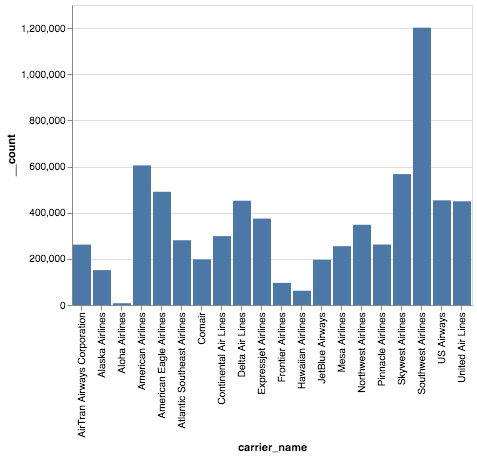

In [4]:
alt.data_transformers.enable('ibis')
alt.renderers.enable("ibis")
c

The only data loaded into the browser for this chart is one row for each carrier, because the counting transformation is pushed to the SQL statement.

## Delay by Month

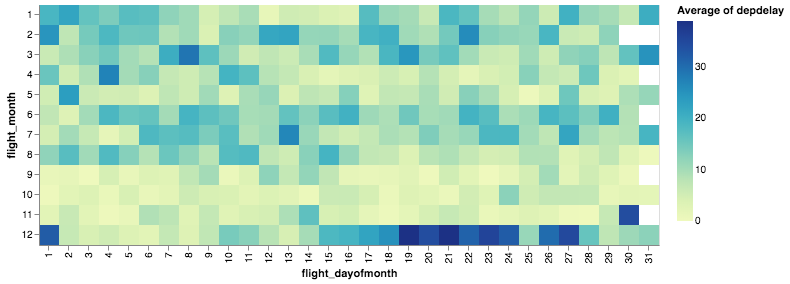

In [5]:
delay_by_month = alt.Chart(t[t.flight_dayofmonth, t.flight_month, t.depdelay]).mark_rect().encode(
    x='flight_dayofmonth:O',
    y='flight_month:O',
    color='average(depdelay)'
)
delay_by_month

## Widgets support: grouping by month
Now let's use widgets to facet this by month:

In [6]:
month = ipywidgets.IntSlider(description='month', min=1, max=12)

def f(month):
    return alt.Chart(t[t.flight_dayofmonth, t.depdelay, t.flight_month][t.flight_month == month]).mark_line().encode(
        x='flight_dayofmonth:O',
        y='average(depdelay)'
    )

out = jupyterlab_omnisci.interactive_chart(f, {'month': month})
ipywidgets.VBox([month, out])

## Combing Tables: Comparing with Political Contributions

Now let's make a graph that also uses data from another table. Let's see how average delay time for flights from a state relates to the average political contribution size.

In [7]:
t_contributions = conn.table("contributions_donotmodify")

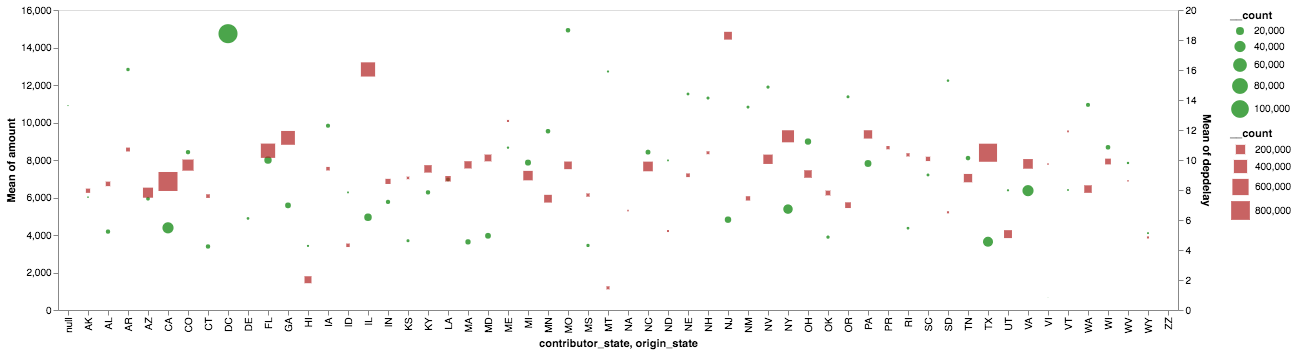

In [8]:
amount_by_state = alt.Chart(
    t_contributions[["contributor_state", "amount"]]
).mark_circle().encode(
    x="contributor_state",
    y=alt.Y("mean(amount):Q", axis=alt.Axis(grid=False)),
    color=alt.Color(value="green"),
    size="count()"
)

delay_by_state = alt.Chart(
    t[["origin_state", "depdelay"]]
).mark_square().encode(
    x="origin_state",
    y=alt.Y(
        "mean(depdelay):Q",
        axis=alt.Axis(grid=False)
    ),
    color=alt.Color(value="firebrick"),
    size="count()"
)

combined = (amount_by_state + delay_by_state).resolve_scale(y='independent', size='independent')
combined

## Debugging

We can use `display_chart` to show some intermediate computatitons for the chart. It does this by enabling different Altair renderers and displaying the chart:

In [9]:
?jupyterlab_omnisci.display_chart

Signature:
jupyterlab_omnisci.display_chart(
    chart: altair.vegalite.v3.api.Chart,
    backend_render=False,
) -> None
Docstring:
Given an Altair chart created around an Ibis expression, this displays the different
stages of rendering of that chart.

This is more for debugging than for anything else.
It iterates through all useful combinations for the renderer,
displays the code you would need to run to enable that setting,
and then displays its output given that setting.



backend_render: Whether to also render with OmniSci's builtin Vega rendering.
File:      /usr/local/miniconda3/envs/tmp/lib/python3.7/site-packages/jupyterlab_omnisci/altair.py
Type:      function


SELECT "carrier_name"
FROM flights_donotmodify

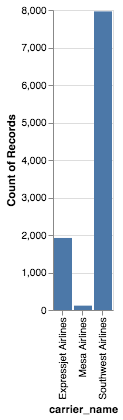

SELECT "carrier_name"
FROM flights_donotmodify

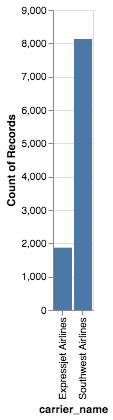

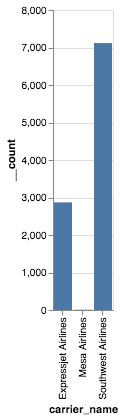

SELECT "carrier_name", count(*) AS __count
FROM (
  SELECT "carrier_name"
  FROM flights_donotmodify
) t0
GROUP BY carrier_name

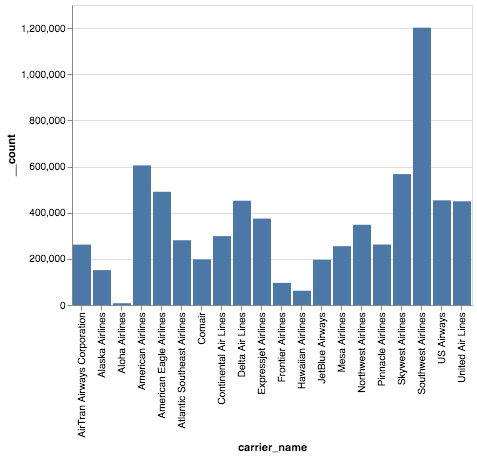

In [10]:
jupyterlab_omnisci.display_chart(c)

SELECT "flight_dayofmonth", "flight_month", "depdelay"
FROM flights_donotmodify

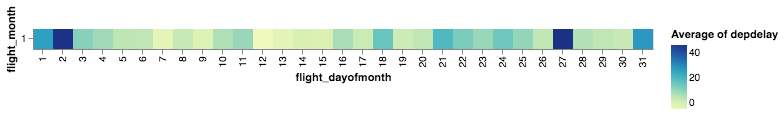

SELECT "flight_dayofmonth", "flight_month", "depdelay"
FROM flights_donotmodify

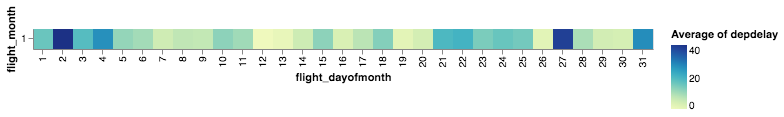

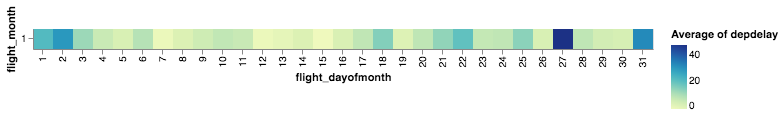

SELECT "flight_dayofmonth", "flight_month",
       avg("depdelay") AS average_depdelay
FROM (
  SELECT "flight_dayofmonth", "flight_month", "depdelay"
  FROM flights_donotmodify
) t0
GROUP BY flight_dayofmonth, flight_month

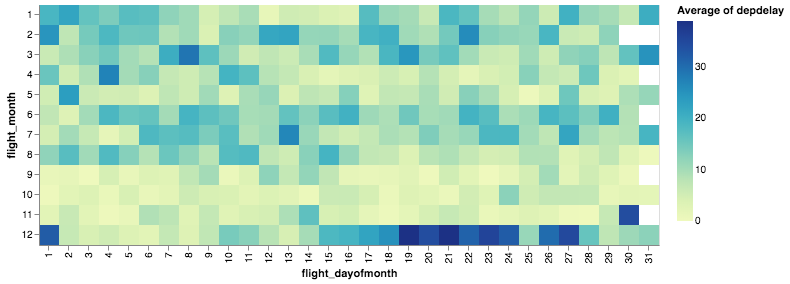

In [11]:
jupyterlab_omnisci.display_chart(delay_by_month)

SELECT "contributor_state", "amount"
FROM contributions_donotmodify
SELECT "origin_state", "depdelay"
FROM flights_donotmodify

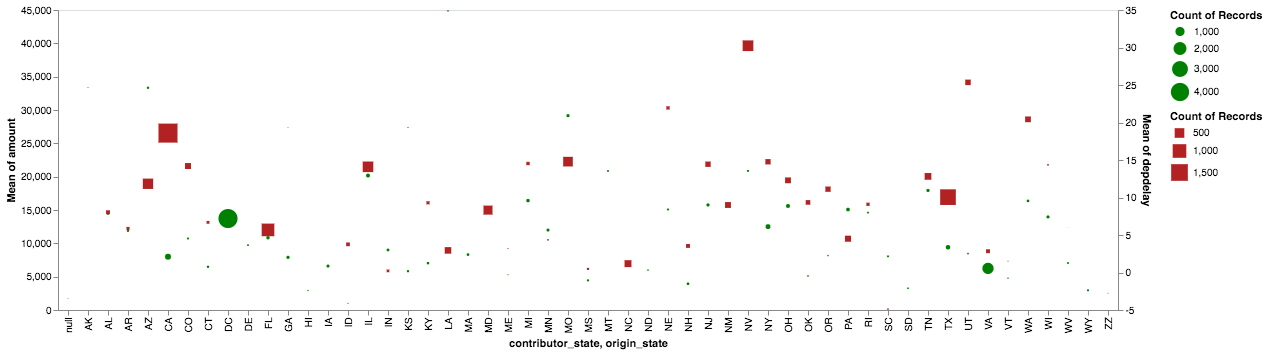

SELECT "contributor_state", "amount"
FROM contributions_donotmodify
SELECT "origin_state", "depdelay"
FROM flights_donotmodify

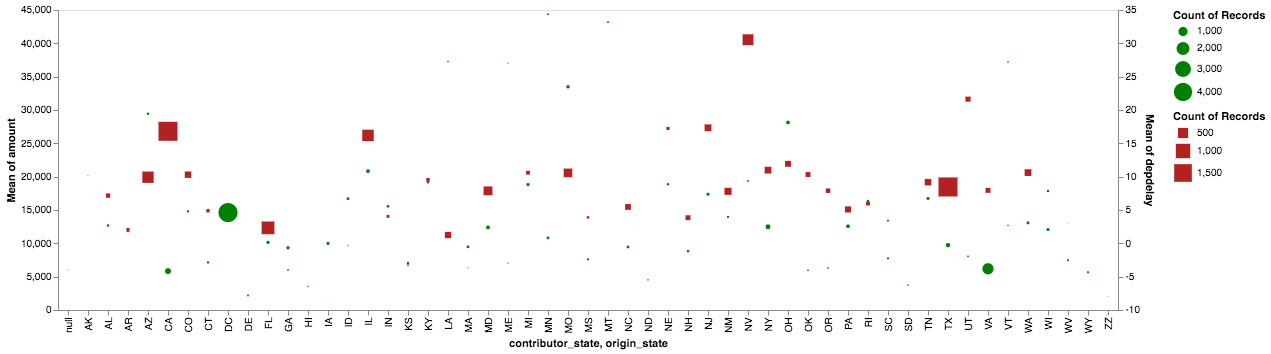

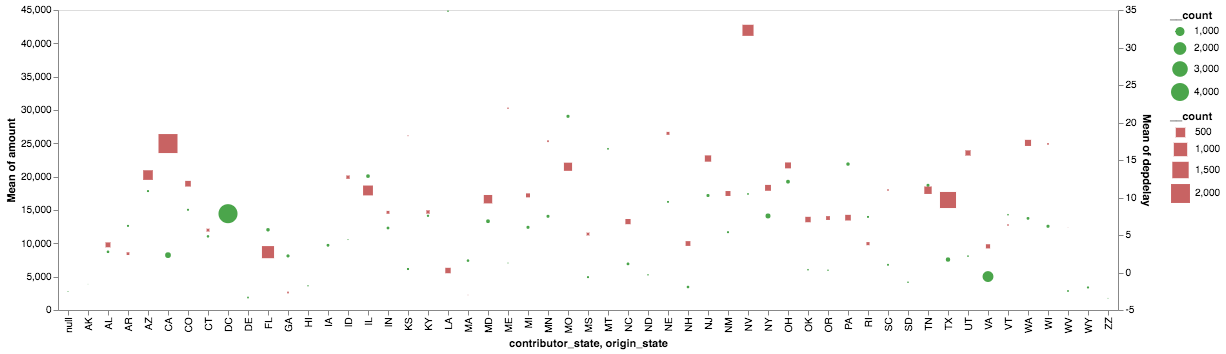

SELECT "contributor_state", count(*) AS __count, avg("amount") AS mean_amount
FROM (
  SELECT "contributor_state", "amount"
  FROM contributions_donotmodify
) t0
GROUP BY contributor_state
SELECT "origin_state", count(*) AS __count, avg("depdelay") AS mean_depdelay
FROM (
  SELECT "origin_state", "depdelay"
  FROM flights_donotmodify
) t0
GROUP BY origin_state

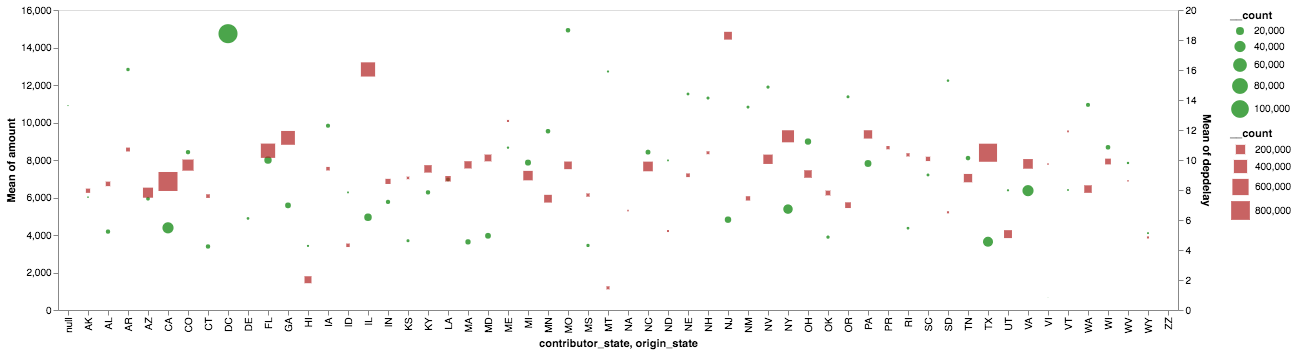

In [12]:
jupyterlab_omnisci.display_chart(combined)